In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


# Step 1 - Importing libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import spacy
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier


In [3]:
pip uninstall tensorflow tensorflow-text tensorflow-hub -y

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
Found existing installation: tensorflow-text 2.16.1
Uninstalling tensorflow-text-2.16.1:
  Successfully uninstalled tensorflow-text-2.16.1
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow==2.15.0 tensorflow-text==2.15.0 tensorflow-hub==0.16.1

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.utils import resample
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import warnings
warnings.filterwarnings('ignore')

2024-09-26 13:50:31.476574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 13:50:31.476641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 13:50:31.478416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
print('Information about the dataset : ')
df.info()

Information about the dataset : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


Following are the insights gained :


* Unamed: 0 is not adding to the information.
* statement column has null values.

In [8]:
print(f'The shape of the dataset is: {df.shape}')

The shape of the dataset is: (53043, 3)


In [9]:
print(f'The columns in the dataset are: {df.columns}')

The columns in the dataset are: Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


Both the columns statement and status are of object type.

In [10]:
df.drop('Unnamed: 0',axis=1,inplace =True)
df.reset_index(drop=True)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [11]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


The column "Unnamed: 0" has been removed successfully. And the indices have been reset.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [13]:
df.shape

(53043, 2)

Now, statement column has null values, time to fix this.

# Step 2 - EDA and Feature Engineering

In [14]:
feature ='statement'
print('The total number of null values in statement column is ',df[feature].isnull().sum()) 
print(f'The percentage of null values is: {np.round(df[feature].isnull().mean(),4)}%')

The total number of null values in statement column is  362
The percentage of null values is: 0.0068%


It's clear that Null values are only 0.0068%, hence they can be dropped and those won't have much impact on the data.

In [15]:
df.dropna(inplace = True)
df.isnull().sum()

statement    0
status       0
dtype: int64

We have successfully dropped the null values.

Text(0, 0.5, 'Count')

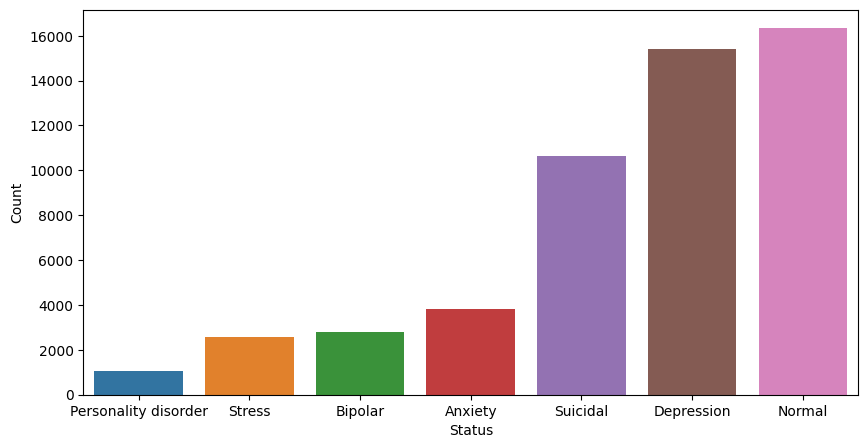

In [16]:
data = df.groupby('status')['statement'].count().sort_values().reset_index()
plt.figure(figsize = (10,5))
sns.barplot(data=data,x='status',y='statement')
plt.xlabel('Status')
plt.ylabel('Count')

So, we can conclude the following from the above plot.
* Maximum people are 'normal' and are not suffering from any mental health condition.
* Depression is the most common mental health problem, followed by suicide.
* There might be correlation in suicidal and depression and depressed people tend to have suicidal thoughts.

In [17]:
data.describe()

,statement
count,7.000000
mean,7525.857143
std,6476.750688
min,1077.000000
25%,2682.000000
50%,3841.000000
75%,13028.000000
max,16343.000000


Let's see how our data stored in dataframe "df" looks like .

In [18]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [19]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


The top value refers to the most frequently occuring value in column of type "object".
Here, the top value is "what do you mean?" and status associated with it is "Normal". 

That means, Normal people have asked this question 22 times.

In [20]:
df[df['statement']== 'what do you mean?']

,statement,status
31098,what do you mean?,Normal
31216,what do you mean?,Normal
31377,what do you mean?,Normal
31522,what do you mean?,Normal
31606,what do you mean?,Normal
31675,what do you mean?,Normal
31788,what do you mean?,Normal
31882,what do you mean?,Normal
31981,what do you mean?,Normal
32022,what do you mean?,Normal


In [21]:
df[df['statement']== 'what do you mean?'].count()

statement    22
status       22
dtype: int64

Now, we'll do some feature engineering by calculating the statement length, number of words, and average word length.

In [22]:
df['statement_length'] = df['statement'].apply(len)
df['num_words'] = df['statement'].apply(lambda x: len(x.split()))
df['avg_word_length'] = np.round(df['statement_length'] / df['num_words'])
df['avg_word_length'] = df['avg_word_length'].map(int)
df.head()

,statement,status,statement_length,num_words,avg_word_length
0,oh my gosh,Anxiety,10,3,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,10,6
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,14,6
3,I've shifted my focus to something else but I'...,Anxiety,61,11,6
4,"I'm restless and restless, it's been a month n...",Anxiety,72,14,5


In [23]:
numeric_feature = [feature for feature in df.columns if df[feature].dtype != 'O']

numeric_feature

['statement_length', 'num_words', 'avg_word_length']

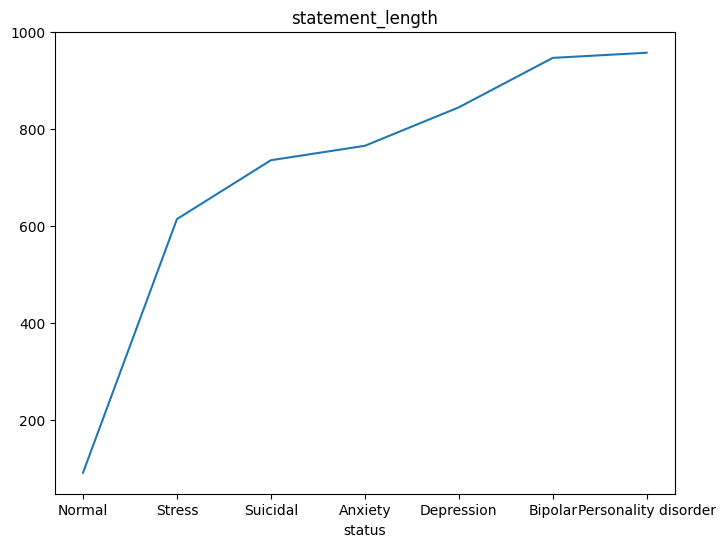

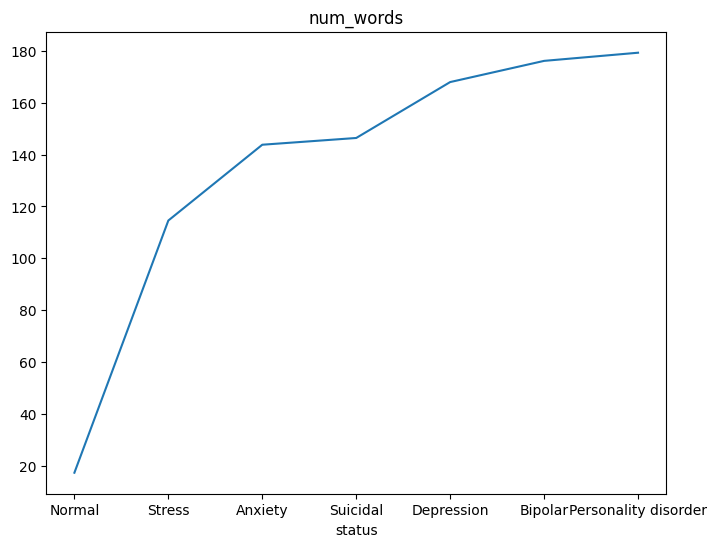

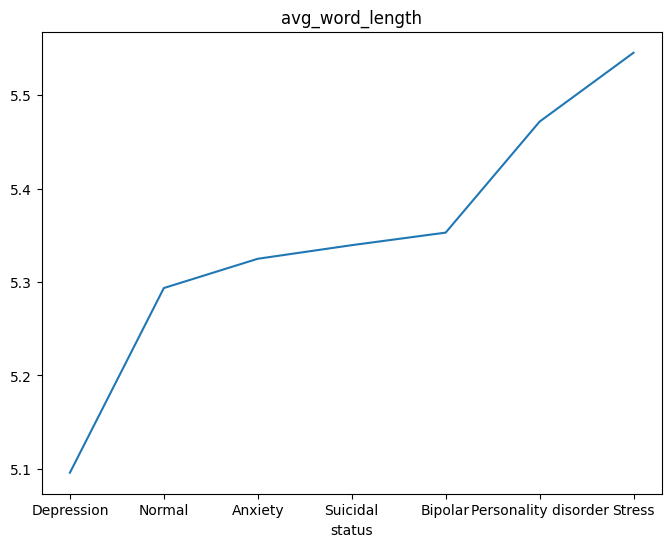

In [24]:
for feature in numeric_feature:
    plt.figure(figsize= (8,6))
    df.groupby('status')[feature].mean().sort_values().plot()
    plt.title(feature)
    plt.show()

We can see that the normal people who do not suffer from any mental disorder speak the least, and people with bipolar personality disorder speak the most.

Let's plot the histogram for all numeric features.

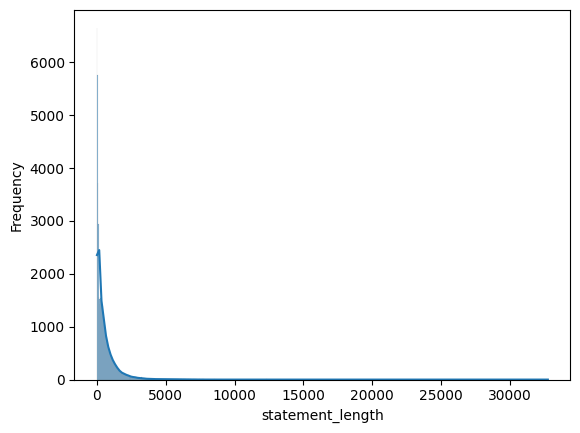

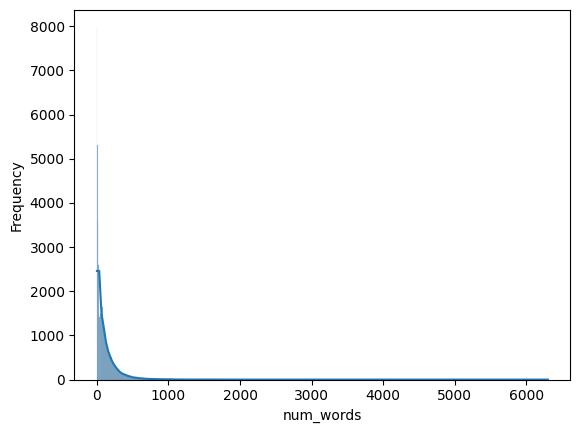

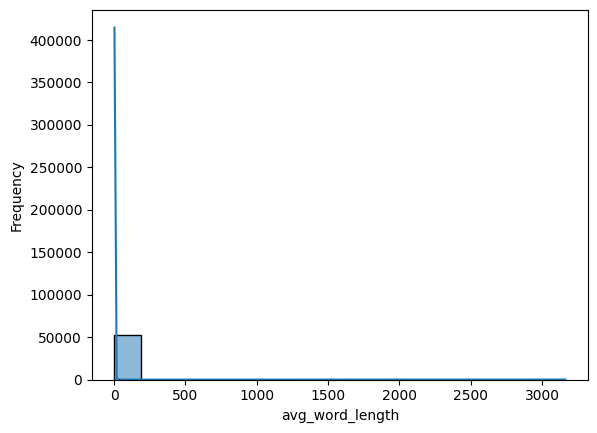

In [25]:
for feature in numeric_feature:
    sns.histplot(data = df, x=feature,kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

As the range of each feature is quite large, let's take a log of each feature and then visualise it.

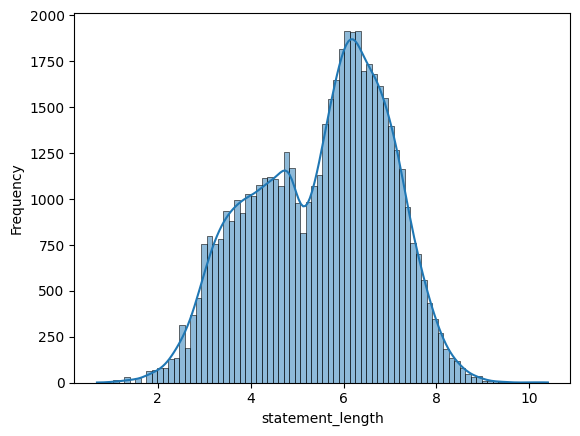

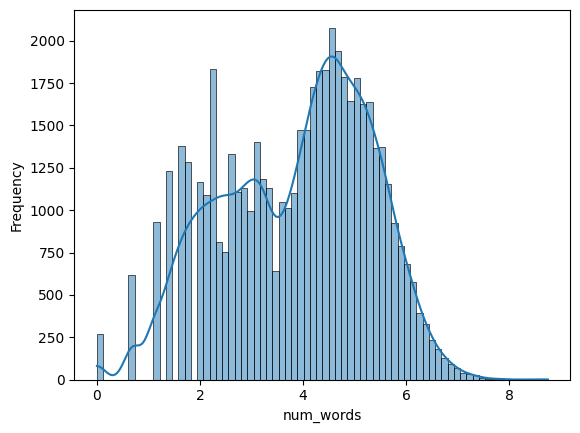

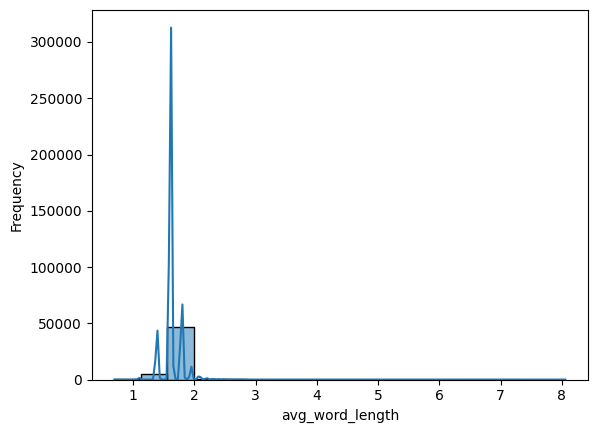

In [26]:
for feature in numeric_feature:
    data = df.copy()
    data[feature] = np.log(data[feature])
    sns.histplot(data = data, x=feature,kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

The above histograms are logs of the features and looks heavily skewed to the right. 
The skewness inidcates bias in the data and impact performance of model. 


To remove the impact of outliers and to normalise the data and make the distribution centered, we are applying log transformation in our features.

In [27]:
for feature in numeric_feature:
    df[feature] = np.log(df[feature])
    


In [28]:
df.head()

,statement,status,statement_length,num_words,avg_word_length
0,oh my gosh,Anxiety,2.302585,1.098612,1.098612
1,"trouble sleeping, confused mind, restless hear...",Anxiety,4.158883,2.302585,1.791759
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,4.356709,2.639057,1.791759
3,I've shifted my focus to something else but I'...,Anxiety,4.110874,2.397895,1.791759
4,"I'm restless and restless, it's been a month n...",Anxiety,4.276666,2.639057,1.609438


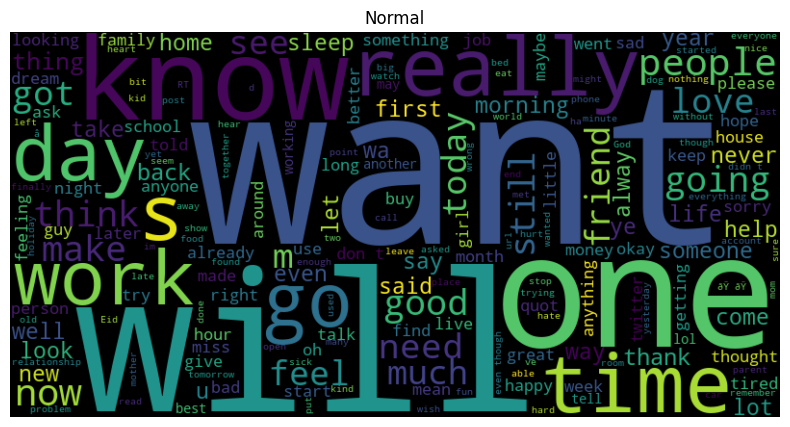

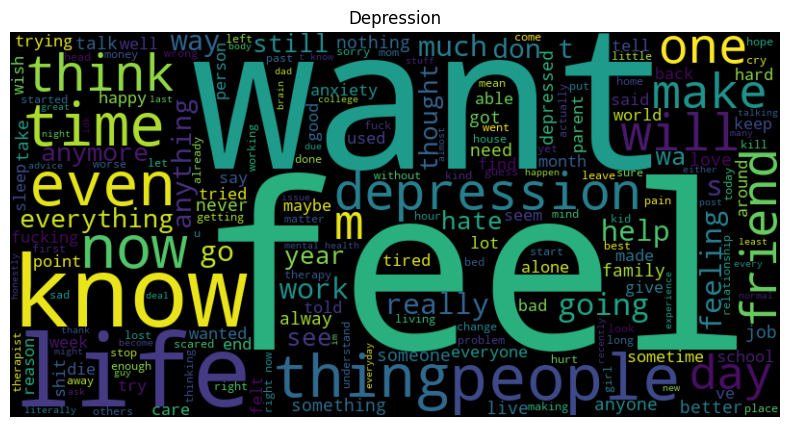

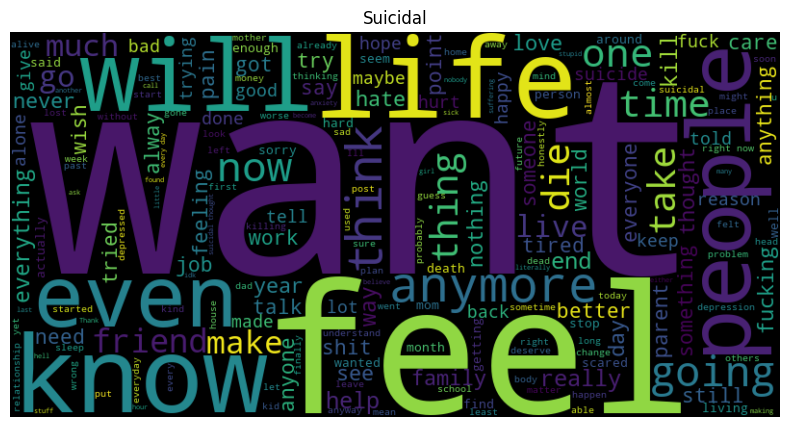

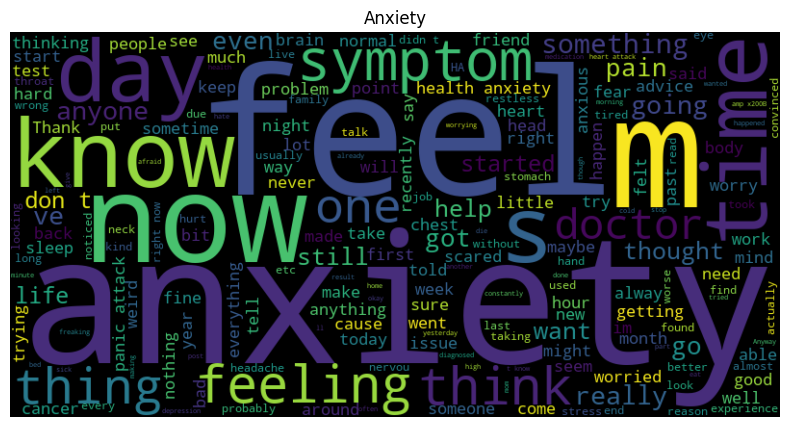

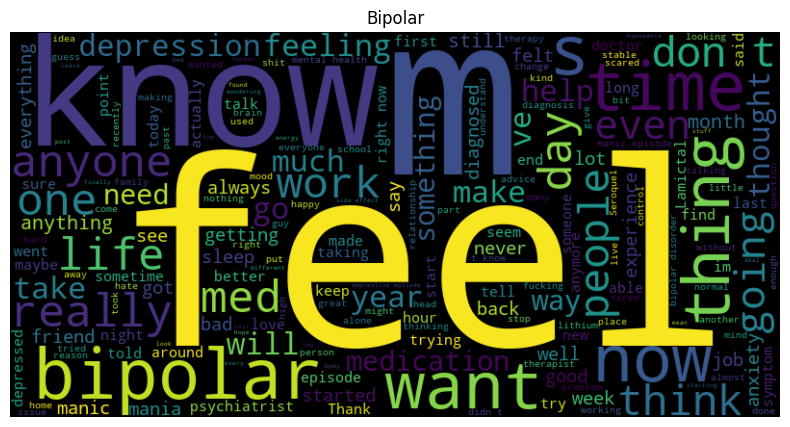

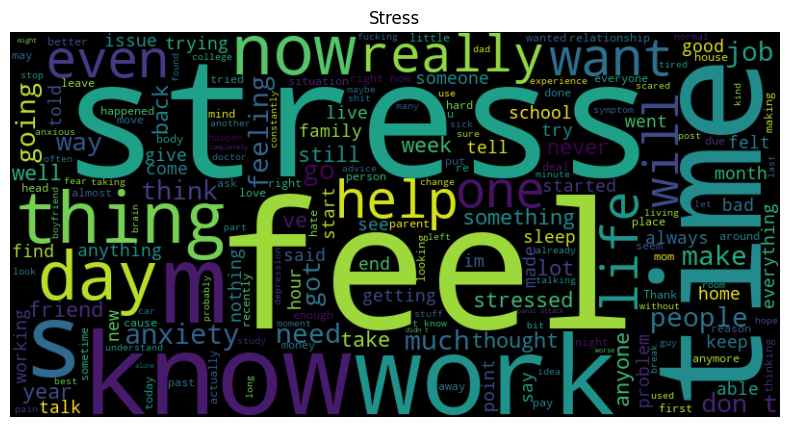

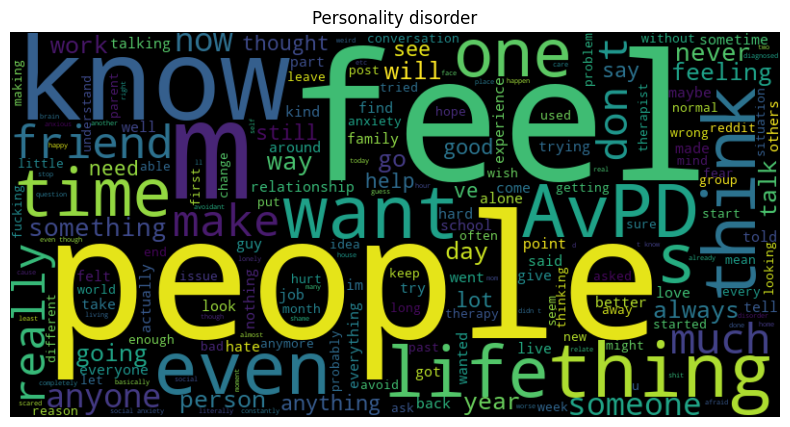

In [29]:

categories = df['status'].value_counts().index

for cat in categories:
    statements = " ".join(df[df['status']==cat]['statement'])
    
    wordcloud = WordCloud(width=800, height=400).generate(statements)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(cat)
    plt.axis('off')
    plt.show()
    

Here, we create a word cloud for each unique status in the status column of the DataFrame. Each word cloud visualizes the frequency of words in the statement column for that particular status.

In [30]:

label_ordered = df['status'].value_counts().index

label_ordered = {k:i for i,k in enumerate(label_ordered,0)}

label_ordered

{'Normal': 0,
 'Depression': 1,
 'Suicidal': 2,
 'Anxiety': 3,
 'Bipolar': 4,
 'Stress': 5,
 'Personality disorder': 6}

Now, we created a dictionary for each key element of status column and value as i index.

In [31]:
df['status'] = df['status'].map(label_ordered)
df.head()

,statement,status,statement_length,num_words,avg_word_length
0,oh my gosh,3,2.302585,1.098612,1.098612
1,"trouble sleeping, confused mind, restless hear...",3,4.158883,2.302585,1.791759
2,"All wrong, back off dear, forward doubt. Stay ...",3,4.356709,2.639057,1.791759
3,I've shifted my focus to something else but I'...,3,4.110874,2.397895,1.791759
4,"I'm restless and restless, it's been a month n...",3,4.276666,2.639057,1.609438


Let's now find the correlation among the features.

<Axes: >

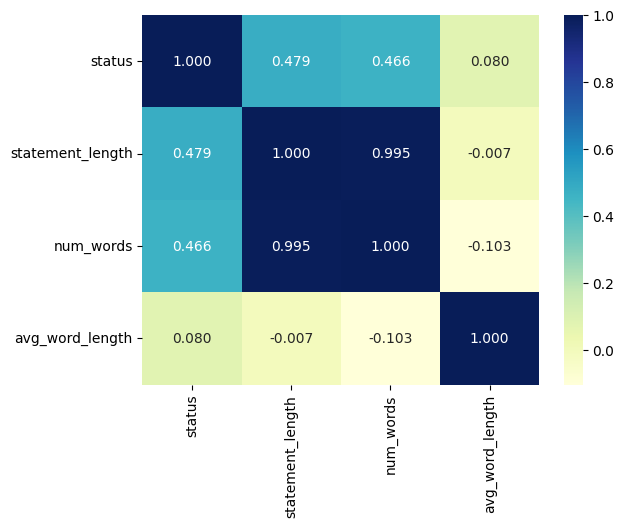

In [32]:
correlation = df[['status','statement_length','num_words','avg_word_length']].corr(method="pearson")
sns.heatmap(correlation,annot=True, fmt=".3f", cmap="YlGnBu")

It's evident that statement_length and num_words have positive correlation with status feature. 

Also, statement_length and num_words are inter correlated with a good correlation factor of 0.995.

## Step 4 : Training the model

In [33]:
df.shape

(52681, 5)

In [34]:
df_sample = df.sample(n=20000,random_state=123)
majority_size = len(df_sample[df_sample['status']==0])

majority_size

6214

We know that maximum people are of "normal" state, anormal state has index value 0.
Thus, we are identifying how many data points are there of normal state from a sample data of 20000 .
Storing that value in variable "majority size".

In [35]:
def resampling_dfs(df):
    resample_minority = resample(df, replace=True, n_samples=majority_size, random_state= 768)
    return resample_minority

With the help of this function, we are upsampling and creating a new DataFrame (resample_minority) by upsampling the minority class to have the same number of samples as the majority class, ensuring a balanced dataset for further analysis.

In [36]:
df_sample_0 = resampling_dfs(df_sample[df_sample['status']==0])
df_sample_1 = resampling_dfs(df_sample[df_sample['status']==1])
df_sample_2 = resampling_dfs(df_sample[df_sample['status']==2])
df_sample_3 = resampling_dfs(df_sample[df_sample['status']==3])
df_sample_4 = resampling_dfs(df_sample[df_sample['status']==4])
df_sample_5 = resampling_dfs(df_sample[df_sample['status']==5])
df_sample_6 = resampling_dfs(df_sample[df_sample['status']==6])

df_new =pd.concat([df_sample_0,df_sample_1,df_sample_2,df_sample_3,df_sample_4,df_sample_5,df_sample_6], axis=0).reset_index(drop=True)

df_new['status'].value_counts()

status
0    6214
1    6214
2    6214
3    6214
4    6214
5    6214
6    6214
Name: count, dtype: int64

Here, we are concatenating the different sample datasets (which we obtained by upsampling original dataset - each containing samples of different statuses)

In [37]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

The line "bert_preprocess" creates a Keras layer for preprocessing text data using a BERT model.
The URL points to a TensorFlow Hub module that handles the preprocessing steps required for BERT, such as tokenization and converting text to input tensors.

This "bert_encoder" line creates another Keras layer, but this time for the BERT encoder itself.

The URL points to a pre-trained BERT model on TensorFlow Hub. This specific model is “uncased,” meaning it treats uppercase and lowercase letters as the same.
The model has 12 layers (L-12), a hidden size of 768 (H-768), and 12 attention heads (A-12).

In [38]:
hub.__version__

'0.16.1'

In [39]:
tf.__version__

'2.15.0'

In [40]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


embedding_model = tf.keras.Model(inputs=[text_input], outputs=[outputs['pooled_output']])

The "text_input" line creates an input layer for a Keras model that expects text data as input.


Then , that text_input is fed into bert preprocessor to preprocess the data.
The input text is tokenized into smaller units called tokens. This involves splitting the text into words, subwords, or characters.
Special tokens like [CLS] (classification token) and [SEP] (separator token) are added to the tokenized text. [CLS] is added at the beginning, and [SEP] is added at the end of each sentence or between sentences.
These tokens are then converted into embeddings.


Then, the embeddings are passed through multiple layers of transformers consisting of self-sttention mechanisms and feed forward neural network.

outputs = bert_encoder(preprocessed_text) means that the bert_encoder function takes the preprocessed text as input and returns the contextualized embeddings as output. These embeddings can then be used for various downstream tasks like classification in our case.


In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_new['statement'], df_new['status'], test_size=0.2, random_state=768)

train_embeddings = embedding_model.predict(X_train)
test_embeddings = embedding_model.predict(X_test)

272/272 [==============================] - 2119s 8s/step


Now, let's classify our embeddings with XGBClassifier.

In [42]:
xgb = XGBClassifier(alpha=0.5, lambda_=1.0,learning_rate=0.05, n_estimators=450)
model = xgb.fit(train_embeddings, y_train,
                eval_set=[(test_embeddings, y_test)], early_stopping_rounds=10)
y_pred = model.predict(test_embeddings)

[0]	validation_0-mlogloss:1.89488
[1]	validation_0-mlogloss:1.84847
[2]	validation_0-mlogloss:1.80509
[3]	validation_0-mlogloss:1.76340
[4]	validation_0-mlogloss:1.72533
[5]	validation_0-mlogloss:1.68908
[6]	validation_0-mlogloss:1.65456
[7]	validation_0-mlogloss:1.62223
[8]	validation_0-mlogloss:1.59136
[9]	validation_0-mlogloss:1.56235
[10]	validation_0-mlogloss:1.53414
[11]	validation_0-mlogloss:1.50757
[12]	validation_0-mlogloss:1.48197
[13]	validation_0-mlogloss:1.45745
[14]	validation_0-mlogloss:1.43324
[15]	validation_0-mlogloss:1.41038
[16]	validation_0-mlogloss:1.38901
[17]	validation_0-mlogloss:1.36844
[18]	validation_0-mlogloss:1.34827
[19]	validation_0-mlogloss:1.32821
[20]	validation_0-mlogloss:1.30832
[21]	validation_0-mlogloss:1.28856
[22]	validation_0-mlogloss:1.27089
[23]	validation_0-mlogloss:1.25272
[24]	validation_0-mlogloss:1.23538
[25]	validation_0-mlogloss:1.21920
[26]	validation_0-mlogloss:1.20358
[27]	validation_0-mlogloss:1.18681
[28]	validation_0-mlogloss:1.1

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1211
           1       0.88      0.82      0.85      1219
           2       0.87      0.88      0.88      1223
           3       0.98      0.99      0.98      1237
           4       0.98      1.00      0.99      1301
           5       0.98      1.00      0.99      1263
           6       1.00      1.00      1.00      1246

    accuracy                           0.95      8700
   macro avg       0.95      0.95      0.95      8700
weighted avg       0.95      0.95      0.95      8700



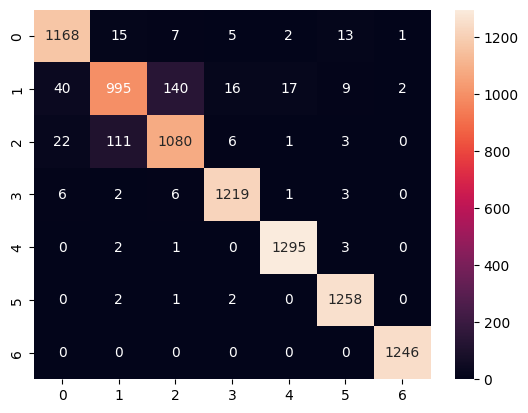

In [43]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot =True, fmt='d')
print(classification_report(y_test,y_pred))